<a href="https://colab.research.google.com/github/arinpamukcu/hiddeneigenmice/blob/main/Last_Copy_of_Main_load_stringer_spontaneous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries 
import ipywidgets as widgets
from ipywidgets import fixed

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


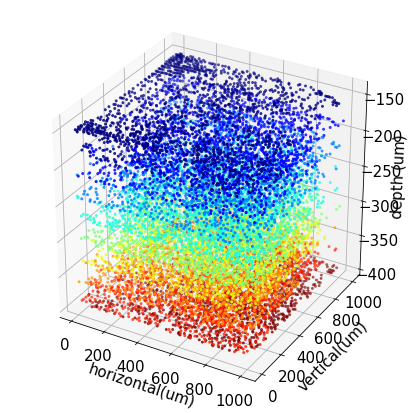

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

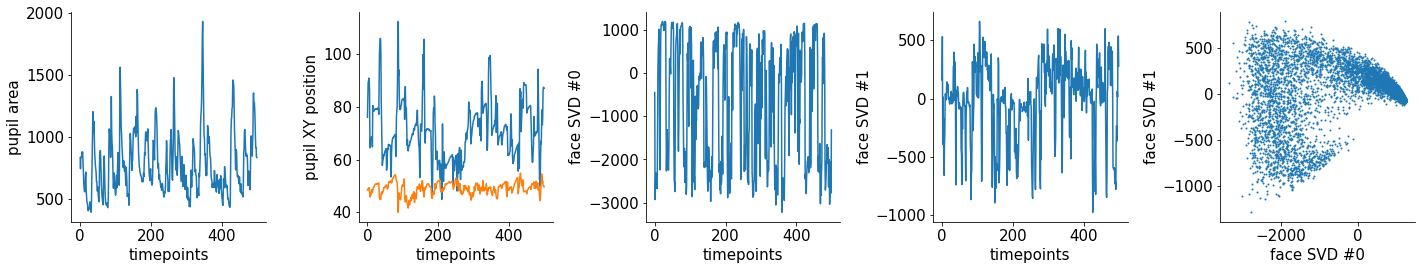

In [ ]:
#@title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1,5,1)
plt.plot(dat['pupilArea'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(1,5,2)
plt.plot(dat['pupilCOM'][:500,:])
ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

ax = plt.subplot(1,5,3)
plt.plot(dat['beh_svd_time'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

ax = plt.subplot(1,5,4)
plt.plot(dat['beh_svd_time'][:500,1])
ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

ax = plt.subplot(1,5,5)
plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

plt.show()

In [ ]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
print(dat['sresp'].shape)
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

(11983, 7018)


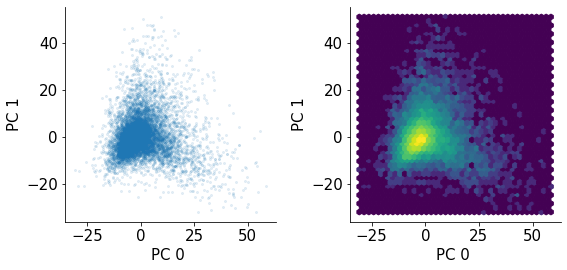

In [ ]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
ax = plt.subplot(1,5,1)
plt.scatter(X[:,0], X[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(X[:,0], X[:,1], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

(7018, 1000)


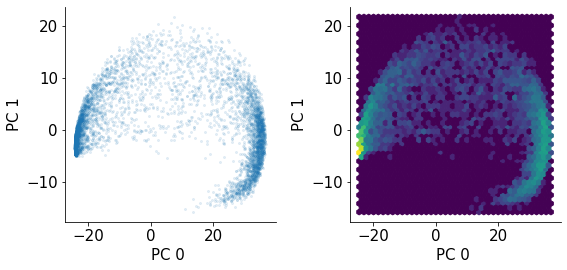

In [ ]:
#@title Take PCA of face SVDs
from scipy.stats import zscore
from sklearn.decomposition import PCA 

print(dat['beh_svd_time'].shape)
ZB = zscore(dat['beh_svd_time'], axis=1)
ZB = np.nan_to_num(ZB)
XB = PCA(n_components = 200).fit_transform(ZB)

#Plot PCs with logarithmic hexbin! 
ax = plt.subplot(1,5,1)
plt.scatter(XB[:,0], XB[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(XB[:,0], XB[:,1], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [ ]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 20, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)
             

     |████████████████████████████████| 80 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 19.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=5895006379eabe5a630f4eb1671fc94d839f8316b259b7a13b89334c5b55ccd7
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52372 sha256=b0028344dc00668652dde1ce2e0e89fd2a4acd430ab88b004877b6ed44077d4d
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
from scipy.ndimage import uniform_filter1d
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis = 1)

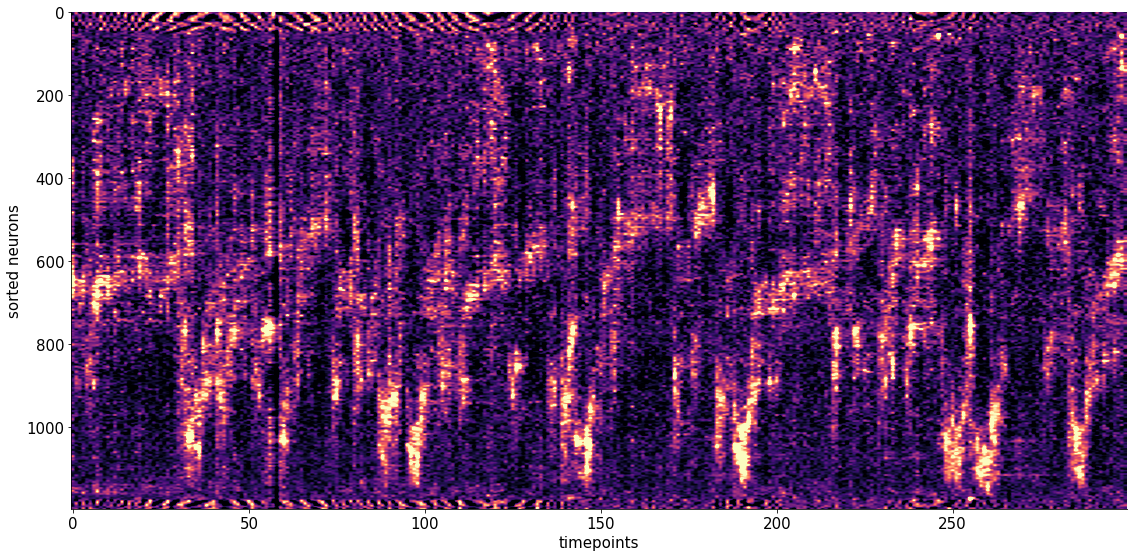

In [ ]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture 

--- 
# Old Stuff 

In [ ]:
#@title Ordinary Least Squares 
def make_design_matrix(x, order=1):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  ########################################################################
  ## TODO for students: create the design matrix ##
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: create the design matrix")
  ########################################################################

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix

def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################

  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y 

  # Compute y_hat 
  y_hat = X @ theta_hat

  # Compute residuals 
  residuals = y - y_hat

  return theta_hat, y_hat, residuals 

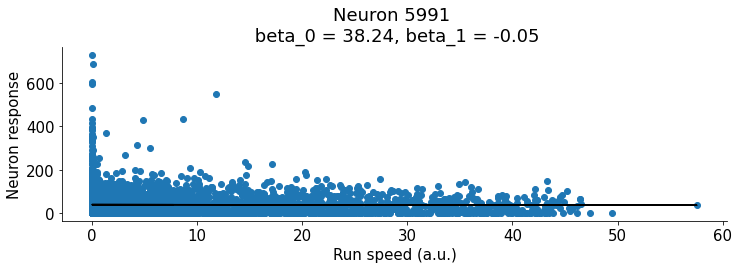

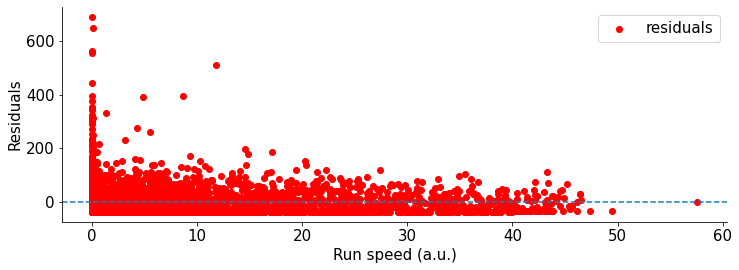

In [ ]:
def plot_run_neuron(neuron_idx):

  # Visualize data 
  # plt.figure();
  ax = plt.subplot(1,2,1)
  plt.scatter(dat['run'], dat['sresp'][neuron_idx,:]);

  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['run'], 1), y=dat['sresp'][neuron_idx,:])
  plt.plot(dat['run'], y_hat, color='k')

  # finish plot 
  plt.xlabel('Run speed (a.u.)'); plt.ylabel('Neuron response');
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0]:.2f}, beta_1 = {theta_hat[1]:.2f}')
  plt.show();

  # plot  
  # plt.figure();
  ax = plt.subplot(1,2,2)
  plt.scatter(dat['run'], residuals,color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Run speed (a.u.)'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_run_neuron, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

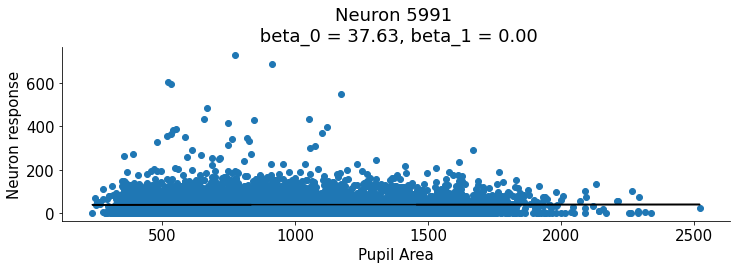

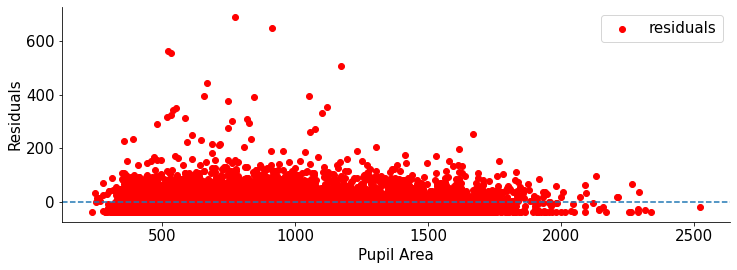

In [ ]:
def plot_pupilArea_neuron(neuron_idx):
  
  # visualize data 
  # plt.figure();
  ax = plt.subplot(1,2,1)
  plt.scatter(dat['pupilArea'], dat['sresp'][neuron_idx,:]);
  
  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['pupilArea'], 1), y=dat['sresp'][neuron_idx,:])
  plt.plot(dat['pupilArea'], y_hat, color='k')

  plt.xlabel('Pupil Area'); plt.ylabel('Neuron response'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0]:.2f}, beta_1 = {theta_hat[1]:.2f}')
  plt.show();

  # plot residuals 
  # plt.figure();
  ax = plt.subplot(1,2,2)
  plt.scatter(dat['pupilArea'], residuals, color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Pupil Area'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_pupilArea_neuron, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

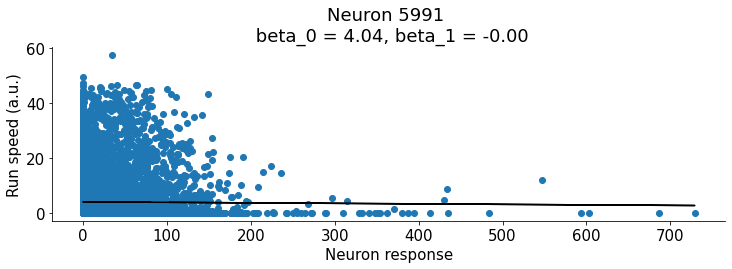

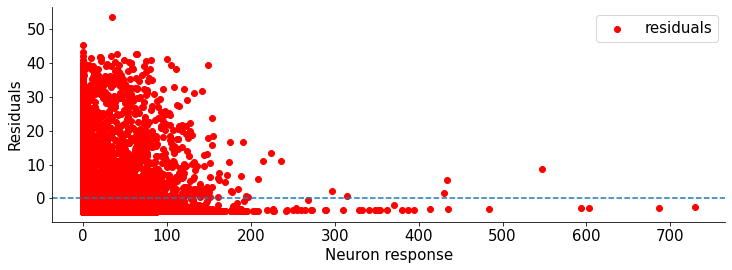

In [ ]:
def plot_neuron_run(neuron_idx):

  # Visualize data 
  # plt.figure();
  ax = plt.subplot(1,2,1)
  plt.scatter(dat['sresp'][neuron_idx,:], dat['run']);

  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['sresp'][neuron_idx,:], 1), y=dat['run'])
  plt.plot(dat['sresp'][neuron_idx,:],y_hat, color='k')

  # finish plot 
  plt.xlabel('Neuron response'); plt.ylabel('Run speed (a.u.)'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0][0]:.2f}, beta_1 = {theta_hat[1][0]:.2f}')
  plt.show();

  # plot residuals 
  # plt.figure();
  ax = plt.subplot(1,2,2)
  plt.scatter(dat['sresp'][neuron_idx,:], residuals,color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Neuron response'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_neuron_run, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

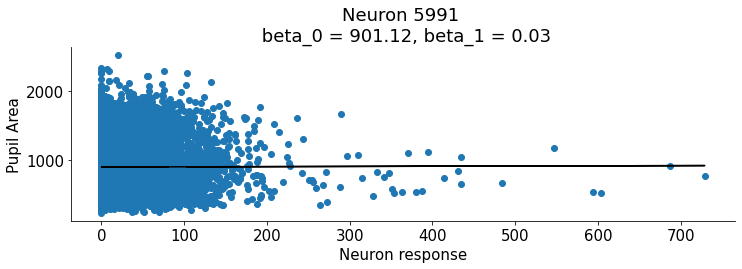

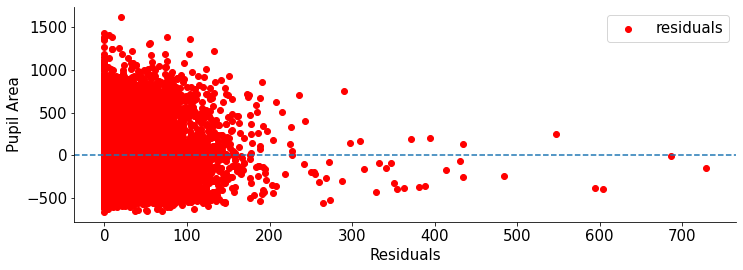

In [ ]:
def plot_neuron_pupilArea(neuron_idx):
  
  # visualize data 
  # plt.figure();
  ax = plt.subplot(1,2,1)
  plt.scatter(dat['sresp'][neuron_idx,:], dat['pupilArea']);
  
  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['sresp'][neuron_idx,:], 1), y=dat['pupilArea'])
  plt.plot(dat['sresp'][neuron_idx,:], y_hat, color='k')

  plt.xlabel('Neuron response'); plt.ylabel('Pupil Area'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0][0]:.2f}, beta_1 = {theta_hat[1][0]:.2f}')
  plt.show();

  # plot residuals 
  # plt.figure();
  ax = plt.subplot(1,2,2)
  plt.scatter(dat['sresp'][neuron_idx,:], residuals, color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Residuals'); plt.ylabel('Pupil Area'); 
  plt.legend()
  plt.show()

_ = widgets.interact(plot_neuron_pupilArea, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

In [ ]:
#@title Duncan's Reduced Rank Regression (RRR)


# def ordinary_least_squares(X, y):
#   """Ordinary least squares estimator for linear regression.

#   Args:
#     x (ndarray): design matrix of shape (n_samples, n_regressors)
#     y (ndarray): vector of measurements of shape (n_samples)

#   Returns:
#     ndarray: estimated parameter values of shape (n_regressors)
#   """
#   ######################################################################
#   ## TODO for students: solve for the optimal parameter vector using OLS
#   # Fill out function and remove
#   # raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
#   ######################################################################

#   # Compute theta_hat using OLS
#   theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y 

#   # Compute y_hat 
#   y_hat = X @ theta_hat

#   # Compute residuals 
#   residuals = y - y_hat

#   return theta_hat, y_hat, residuals 

# def sort_evals_descending(evals, evectors):
#   """
#   Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
#   eigenvectors to be in first two quadrants (if 2D).

#   Args:
#     evals (numpy array of floats)    : Vector of eigenvalues
#     evectors (numpy array of floats) : Corresponding matrix of eigenvectors
#                                         each column corresponds to a different
#                                         eigenvalue

#   Returns:
#     (numpy array of floats)          : Vector of eigenvalues after sorting
#     (numpy array of floats)          : Matrix of eigenvectors after sorting
#   """

#   index = np.flip(np.argsort(evals))  # sort in ascending order and then flip index values 
#   evals = evals[index] # re-organize 
#   evectors = evectors[:, index] # re-organize 
#   # if evals.shape[0] == 2:
#   #   if np.arccos(np.matmul(evectors[:, 0],
#   #                          1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
#   #     evectors[:, 0] = -evectors[:, 0]
#   #   if np.arccos(np.matmul(evectors[:, 1],
#   #                          1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
#   #     evectors[:, 1] = -evectors[:, 1]
#   return evals, evectors

# def RRR(x, y, rank):
#   '''
#   Rank ridge regression 
  
#   Resources:
  
#   https://stats.stackexchange.com/questions/152517/what-is-reduced-rank-regression-all-about
#   https://www.youtube.com/watch?v=AYKmzhbsTwg

#   INPUTS:
#   x: predictor 
#   y: output 
#   rank: rank for regression 

#   OUTPUT:
#   beta_hat_RRR: reduced rank regression coefficients 

#   '''

#   # perform OLS 
#   X = make_design_matrix(x);
#   theta_hat, y_hat, residuals = ordinary_least_squares(X, y);

#   # 
#   print(f'y.T = \n {y.T} \n')
#   print(f' shape = \n {np.shape(y.T)} \n')
#   print(f'X = \n {X} \n')
#   print(f'shape = \n {X.shape} \n')
#   print(f'theta_hat = \n {theta_hat} \n')
#   print(f'shape = \n {theta_hat.shape} \n')
#   print(f'np.vstack(theta_hat) = \n {np.vstack(theta_hat)} \n')
#   print(f'shape = \n {np.vstack(theta_hat).shape} \n')
#   M = y.T @ X @ np.vstack(theta_hat)
#   print(M)
#   eigval, evectors = np.linalg.eig(M) # unsorted eigenvalues and eigenvectors 
#   # Sort the eigenvalues in descending order
#   evals, evectors = sort_evals_descending(eigval, evectors)

#   # select columns wanted 
#   # create matrix to multiply together to get values 
#   multM = np.zeros_like(evectors);
#   multM[:,0:rank-1]

#   W = evectors * multM

#   beta_hat_RRR = theta_hat @ W @ W.T


#   return beta_hat_RRR


In [ ]:
# # tested reduced rank regression 
# x = np.array([1,2,3,4,5,6,7,8,9,10]);
# y = np.tile(x, (3,1)) + np.random.normal(0,1,(3,10));

# # visualize 
# plt.figure(figsize=(5,5));
# for i in range(3):
#   plt.scatter(x,y[i,:])

# plt.show();

# # perform the regression (not completed)
# beta_hat_RRR = RRR(x,y, rank=1)

# New Stuff

In [ ]:
#@title Organize train and test data according to the paper
# print(Z.shape[1]//60)
# print(x.shape) 
n_train = np.array([]) 
n_test  = np.array([])
i_train = np.array([])
i_test  = np.array([])
# Every 72s = 60 bins of 1.2s
for i in range(0, Z.shape[1]-60,60):
   if ((i/60) % 2 == 0):
    i_train = np.concatenate((i_train,np.arange(i,i+60)),axis=0)
   else:
    i_test = np.concatenate((i_test,np.arange(i,i+60)),axis=0)   

# print(i_test.shape)
# print(i_train.shape)
# Make into array of arrays
i_train = [int(i_train[i]) for i in np.arange(0,len(i_train))]
i_test = [int(i_test[i]) for i in np.arange(0,len(i_test))]


# Sort by location every 60 microns
for i in range(0, len(x)):
   if ((x[i]//60) % 2 == 0):
    n_train = np.concatenate((n_train,np.array([i])),axis=0)
   else:
    n_test = np.concatenate((n_test,np.array([i])),axis=0)   
# print(n_train.shape)
# print(n_test.shape)

n_train = n_train[0:n_test.shape[0]]

# print(n_train.shape)
# print(n_test.shape)

# Make into array of arrays
n_train = [[int(n_train[i])] for i in np.arange(0,len(n_train))]
n_test  = [[int(n_test[i])]  for i in np.arange(0,len(n_test))]


In [ ]:
#@title shared variant Component Analysis (svCA)
def SVCA(data, num_pcs, n_train, n_test, i_train, i_test): 
  # Translated from: https://github.com/MouseLand/stringer-pachitariu-et-al-2018a/blob/master/multiDactivity/SVCA.m

  # INPUTS:
  # data: data matrix (neuron X timepoint)
  # num_pcs: number of principle components 
  # n_train: vector of train neurons slices
  # n_test: vector of test neurons slices
  # i_train: vector of train time points slices
  # i_test: vector of test time points slices 

  # OUTPUT:
  # sneur: shared variance of each covariance component 
  # vneur: total variance of each covariance component 
  # u: left eigenvectors of covariance matrix between n_train and n_test on i_trian 
  # v: right eigenvectors of covariance matrix between n_train and n_test on i_trian 

  # print output to see how indexing works 
  # print(f'Data = \n {data} \n')
  # print(f'neuron_train = \n {n_train} \n')
  # print(f'time_train = \n {i_train} \n')
  # print(f'data[neuron_train, time_trian] = \n {data[n_train, i_train]} \n')
  # comment out when don't want print outs 

  covar =  data[n_train, i_train] @ data[n_train, i_train].T; # get covariance of training subset 
  u,_,v = np.linalg.svd(covar); # single value decomposition 
  u = u[:,0:num_pcs]; # take parts of u matrix 
  v = v[:,0:num_pcs]; # 
  s1 = u.T @ data[n_train, i_train]; # project data onto left eigenvectors
  s2 = v.T @ data[n_test, i_test]; # project data onto right eigenvectors 
  sneur = np.sum(s1 * s2, axis=1);
  varneur = np.sum(s1**2 + s2**2, axis=1)/2; 

  return sneur, varneur, u, v

In [ ]:
# # random test 
# data = np.random.randint(low=0, high=10, size=[10,10]); 
# neuron_test = [[0],[1],[2],[3],[4]];
# neuron_train = [[5],[6],[7],[8],[9]]; 
# time_test = [0,1,2,3,4];
# time_train = [5,6,7,8,9]; 
# sneur, varneur, u, v = SVCA(data, 10, neuron_train, neuron_test, time_train, time_test)

# print(f'Shared variance of each covariance component = \n {sneur}')
# print('\n')
# print(f'Total variance of each covariance component = \n {varneur}')
# print('\n')
# print(f'Left eigenvectors of covariance matrix = \n {u}')
# print('\n')
# print(f'Right eigen vectors of covariance matrix = \n {v}')

0.29585242


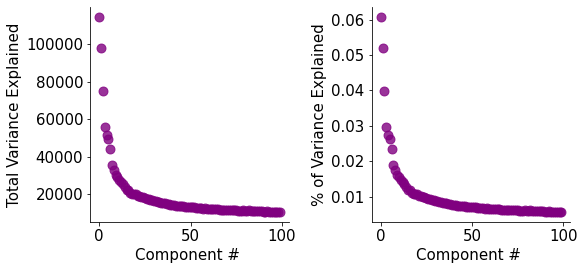

In [ ]:
#@title svCA on paper data
data = Z; 
sneur, varneur, u, v = SVCA(data, 100, n_train, n_test, i_train, i_test)

# print(f'Shared variance of each covariance component = \n {sneur}')
# print('\n')
# print(f'Total variance of each covariance component = \n {varneur}')
# print('\n')
# print(f'Left eigenvectors of covariance matrix = \n {u}')
# print('\n')
# print(f'Right eigen vectors of covariance matrix = \n {v}')


# Make Screee plot
ax = plt.subplot(1,5,1)
plt.scatter(np.arange(0,len(varneur)), varneur, s = 80, alpha = .8, color='purple')
ax.set(xlabel = 'Component # ', ylabel = 'Total Variance Explained');
ax = plt.subplot(1,5,2)
plt.scatter(np.arange(0,len(varneur)), varneur/(np.sum(varneur)), s = 80, alpha = .8, color='purple')
ax.set(xlabel = 'Component # ', ylabel = '% of Variance Explained');
print(np.sum(varneur[0:9])/np.sum(varneur))

In [ ]:
#@title Reduced Rank Regression (RRR)
# Adapted from: https://github.com/riscy/machine_learning_linear_models/blob/master/reduced_rank_regressor.py
import numpy as np
from scipy import sparse

class ReducedRankRegressor(object):
    """
    Reduced Rank Regressor (linear 'bottlenecking' or 'multitask learning')
    - X is an n-by-d matrix of features.
    - Y is an n-by-D matrix of targets.
    - rrank is a rank constraint.
    - reg is a regularization parameter (optional).
    """
    def ideal_data(num, dimX, dimY, rrank, noise=1):
        """Low rank data"""
        X = np.random.randn(num, dimX)
        W = np.dot(np.random.randn(dimX, rrank), np.random.randn(rrank, dimY))
        Y = np.dot(X, W) + np.random.randn(num, dimY) * noise
        return X, Y

    def __init__(self, X, Y, rank, reg=None):
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        if np.size(np.shape(Y)) == 1:
            Y = np.reshape(Y, (-1, 1))
        if reg is None:
            reg = 0
        self.rank = rank

        CXX = np.dot(X.T, X) + reg * sparse.eye(np.size(X, 1))
        CXY = np.dot(X.T, Y)
        _U, _S, V = np.linalg.svd(np.dot(CXY.T, np.dot(np.linalg.pinv(CXX), CXY)))
        self.W = V[0:rank, :].T
        self.A = np.dot(np.linalg.pinv(CXX), np.dot(CXY, self.W)).T

    def __str__(self):
        return 'Reduced Rank Regressor (rank = {})'.format(self.rank)

    def predict(self, X):
        """Predict Y from X."""
        if np.size(np.shape(X)) == 1:
            X = np.reshape(X, (-1, 1))
        # print(np.dot(X, np.dot(self.A.T, self.W.T)))
        return np.dot(X, np.dot(self.A.T, self.W.T))


In [ ]:
from scipy import around
from scipy import size
from scipy.linalg import norm
from numpy.random import seed

DIM_X = 20                      # dimensionality of input
DIM_Y = 15                      # dimensionality of output
RANK = 10                       # internal rank/bottleneck
NOISE_SCALE = 1.0
NUM_SAMPLES = 5000
SPLIT = int(NUM_SAMPLES/2)      # train/test split
REG = 1e-6                      # regularization on the model


def sqerr(matrix1, matrix2):
    """Squared error (frobenius norm of diff) between two matrices."""
    return around(pow(norm(matrix1 - matrix2, 'fro'), 2) / size(matrix2, 0), 5)


if __name__ == '__main__':
    seed(10)
    model=ReducedRankRegressor
    # generate the data:
    print(model.ideal_data.__doc__)
    XX, YY = model.ideal_data(NUM_SAMPLES, DIM_X, DIM_Y, RANK, NOISE_SCALE)
    # run each of the regressors against it:
    regressor =  ReducedRankRegressor(XX[:SPLIT], YY[:SPLIT], RANK, REG)
    print('  {}'.format(regressor))
    training_error = sqerr(regressor.predict(XX[:SPLIT]), YY[:SPLIT])
    testing_error = sqerr(regressor.predict(XX[SPLIT:]), YY[SPLIT:])
    print('    Training error: {}\n    Testing error: {}'
                  .format(training_error, testing_error))

Low rank data
  Reduced Rank Regressor (rank = 10)
    Training error: 14.74411
    Testing error: 15.25541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.size is deprecated and will be removed in SciPy 2.0.0, use numpy.size instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.around is deprecated and will be removed in SciPy 2.0.0, use numpy.around instead


(5000, 15)


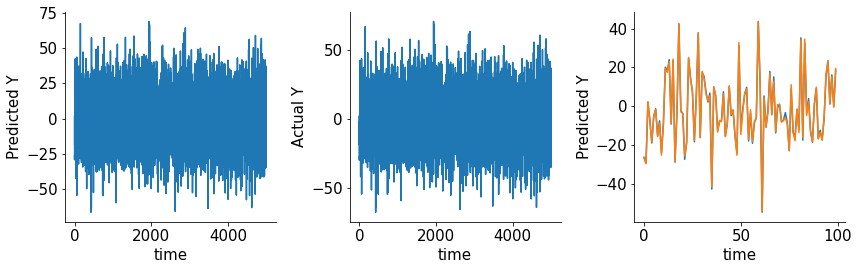

In [ ]:
# print(XX.shape)
# print(YY.shape)
# print(regressor)
# print(regressor.W.shape)
# print(regressor.A.shape)

# Rank components predictions

Y_pred=np.dot(XX, np.dot(regressor.A.T, regressor.W.T))

print(Y_pred.shape)

ax = plt.subplot(1,5,1)
plt.plot(np.arange(0,Y_pred.shape[0]), Y_pred[:,0])
ax.set(xlabel = 'time', ylabel = 'Predicted Y');
ax = plt.subplot(1,5,2)
plt.plot(np.arange(0,len(YY)), YY[:,0])
ax.set(xlabel = 'time', ylabel = 'Actual Y');


ax = plt.subplot(1,5,3)
plt.plot(np.arange(0,100), Y_pred[0:100,0])
plt.plot(np.arange(0,100), YY[0:100,0])
ax.set(xlabel = 'time', ylabel = 'Predicted Y');

In [ ]:
#@title Find residuals
def true_v_pred(XX, YY, y_col, regressor, plot_yn='y'):
  '''
  Visualize how well prediction made

  INPUT:
  XX: x matrix 
  YY: y matrix 
  y_col: y column to plot 
  regressor: regressor object 
  plot_yn: plots, y/n?

  OUTPUT:
  residuals: residual values 
  '''

  # true y-values 
  Y_true = YY; 

  # predicted y-values 
  Y_pred=np.dot(XX, np.dot(regressor.A.T, regressor.W.T)); 

  r = Y_pred.shape[0];
  c = Y_pred.shape[1];
  residual = np.squeeze(np.array(Y_pred[0:r,y_col])) - YY[0:r,y_col]

  if plot_yn == 'y':
   
    # visualize

    ax = plt.subplot(1,5,1)
    plt.plot(np.arange(0,r), Y_pred[:,y_col])
    ax.set(xlabel = 'time', ylabel = 'Predicted Y');

    ax = plt.subplot(1,5,2)
    plt.plot(np.arange(0,r), YY[:,y_col])
    ax.set(xlabel = 'time', ylabel = 'Actual Y');

    ax = plt.subplot(1,5,3)
    plt.plot(np.arange(0,r), Y_pred[0:r,0])
    plt.plot(np.arange(0,r), YY[0:r,0])
    ax.set(xlabel = 'time', ylabel = 'Predicted Y');

    ax = plt.subplot(1,5,4);
    plt.scatter(np.squeeze(np.array(Y_pred[0:r,y_col])), YY[0:r,y_col])
    plt.plot(ax.get_xlim(), ax.get_ylim(), color='k')
    ax.set(xlabel='Y prediction', ylabel = 'Y true')
    

    ax = plt.subplot(1,5,5)
    plt.scatter(np.arange(0,r), residual)
    plt.plot(ax.get_xlim(), [0, 0], color='k')
    ax.set(xlabel = 'time', ylabel = 'Residual')

  return residual

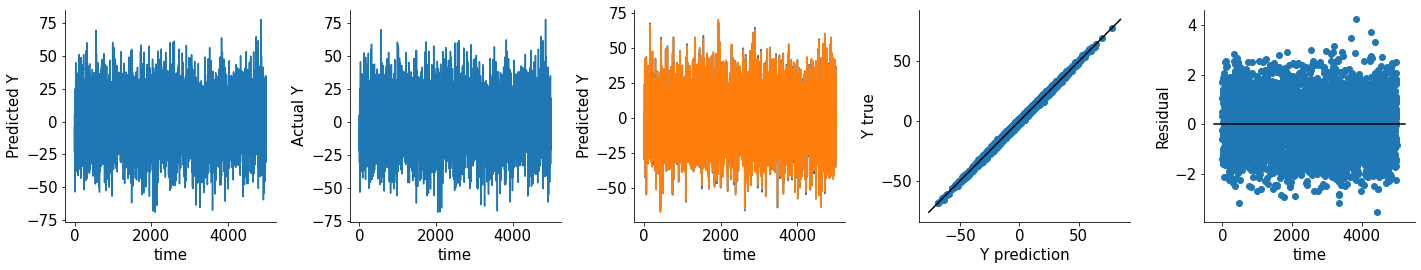

In [ ]:
def vis_resid(y_col):
  residual_test = true_v_pred(XX, YY, y_col, regressor)

_ = widgets.interact(vis_resid, y_col = (0,14,1))

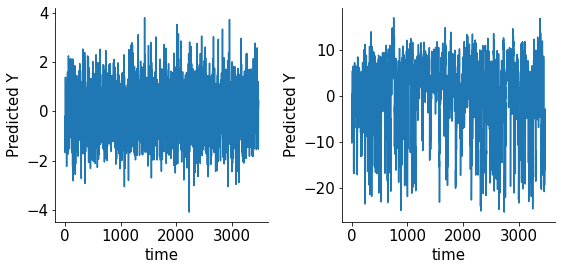

In [ ]:
#@title Format neural data

# print(sneur.shape)
# print(varneur.shape)
# print(u.shape)
# print(v.shape)
# print(data[n_train, i_train].shape)

Sc_left = v.T @ data[n_test, i_test]; # project data onto right eigenvectors 
Sc_right = u.T @ data[n_train, i_train]; # project data onto left eigenvectors

# print(Sc_left.shape)
# print(Sc_right.shape)

ax = plt.subplot(1,5,1)
plt.plot(np.arange(0,Sc_left.shape[1]), Sc_left[1,:])
ax.set(xlabel = 'time', ylabel = 'Predicted Y');

ax = plt.subplot(1,5,2)
plt.plot(np.arange(0,Sc_right.shape[1]), Sc_right[0,:])
ax.set(xlabel = 'time', ylabel = 'Predicted Y');

In [ ]:
#@title Format behavioral data
sbeh = dat['beh_svd_time'] #behavior input
# print(sbeh.shape)

i_train = np.array([])
i_test  = np.array([])
# Every 72s = 60 bins of 1.2s
for i in range(0, sbeh.shape[0]-60,60): #behavior input
   if ((i/60) % 2 == 0):
    i_train = np.concatenate((i_train,np.arange(i,i+60)),axis=0)
   else:
    i_test = np.concatenate((i_test,np.arange(i,i+60)),axis=0)   

# print(i_test.shape)
# print(i_train.shape)
# Make into array of arrays
i_train = [int(i_train[i]) for i in np.arange(0,len(i_train))]
i_test = [int(i_test[i]) for i in np.arange(0,len(i_test))]

sbeh_train = sbeh[i_train,:] #behavior input
sbeh_test  = sbeh[i_train,:] #behavior input

# print(sbeh_train.shape)
# print(sbeh_test.shape)

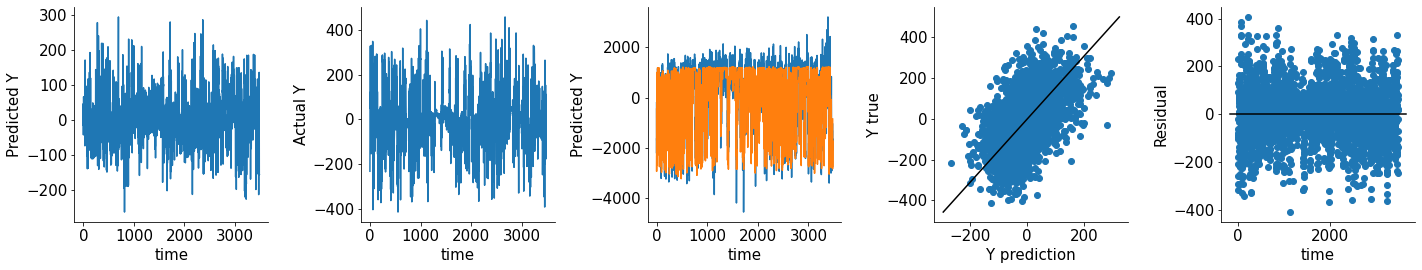

In [ ]:
#@title RRR on paper data
DIM_X = 50                      # dimensionality of input
DIM_Y = 1                      # dimensionality of output
RANK = 16                       # internal rank/bottleneck

REG = 1e-3 
# print(sbeh_test.shape)
# print(Sc_right.shape)

if __name__ == '__main__':
    seed(10)
    model=ReducedRankRegressor
    # generate the data:
    print(model.ideal_data.__doc__)
    #XX, YY = model.ideal_data(sbeh_test.shape[0], DIM_X, DIM_Y, RANK, NOISE_SCALE)
    XX  = Sc_right.T #neural input
    YY  = sbeh_test #behavior input
     # run each of the regressors against it:
    regressor =  ReducedRankRegressor(XX[:SPLIT], YY[:SPLIT], RANK, REG)
    print('  {}'.format(regressor))
    training_error = sqerr(regressor.predict(XX[:SPLIT]), YY[:SPLIT])
    testing_error = sqerr(regressor.predict(XX[SPLIT:]), YY[SPLIT:])
    print('    Training error: {}\n    Testing error: {}'
                  .format(training_error, testing_error))
def vis_resid(y_col):
  residual_test = true_v_pred(XX, YY, y_col, regressor)

_ = widgets.interact(vis_resid, y_col = (0,16,1))

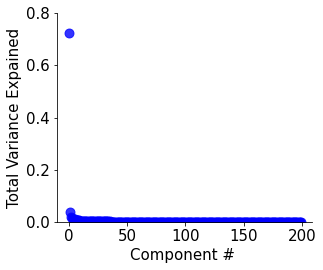

In [ ]:
# PCA on behavior data #Face Energy SCVA + PCA
pca = PCA(n_components=200)
X_beh = pca.fit_transform(sbeh)
exp_var_pca = pca.explained_variance_ratio_
ax = plt.subplot(1,5,1)
plt.scatter(np.arange(0,len(exp_var_pca)), exp_var_pca, s = 80, alpha = .8, color='b')
ax.set_ylim(0, 0.8)
ax.set(xlabel = 'Component # ', ylabel = 'Total Variance Expained');
# print(X_beh.shape)
# ax = plt.subplot(1,5,2)
# plt.plot(np.arange(0,200), X_beh[0:200,0])
# plt.plot(np.arange(0,200), X_beh[0:200,1])
# plt.plot(np.arange(0,200), X_beh[0:200,2])
# plt.plot(np.arange(0,200), X_beh[0:200,3])
# #ax.set(xlabel = 'Component # ', ylabel = 'Total Variance Expained');
# ax = plt.subplot(1,5,3)
# plt.plot(np.arange(0,200), X_beh[200:400,0])
# plt.plot(np.arange(0,200), X_beh[200:400,1])
# plt.plot(np.arange(0,200), X_beh[200:400,2])
# plt.plot(np.arange(0,200), X_beh[200:400,3])
# ax = plt.subplot(1,5,4)
# plt.plot(np.arange(0,200), X_beh[400:600,0])
# plt.plot(np.arange(0,200), X_beh[400:600,1])
# plt.plot(np.arange(0,200), X_beh[400:600,2])
# plt.plot(np.arange(0,200), X_beh[400:600,3])
# ax = plt.subplot(1,5,5)
# plt.plot(np.arange(0,200), X_beh[600:800,0])
# plt.plot(np.arange(0,200), X_beh[600:800,1])
# plt.plot(np.arange(0,200), X_beh[600:800,2])
# plt.plot(np.arange(0,200), X_beh[600:800,3])

sbeh=X_beh
sbeh_train = sbeh[i_train,0:20] 
sbeh_test  = sbeh[i_test,0:20]


# print( exp_var_pca[0:10])

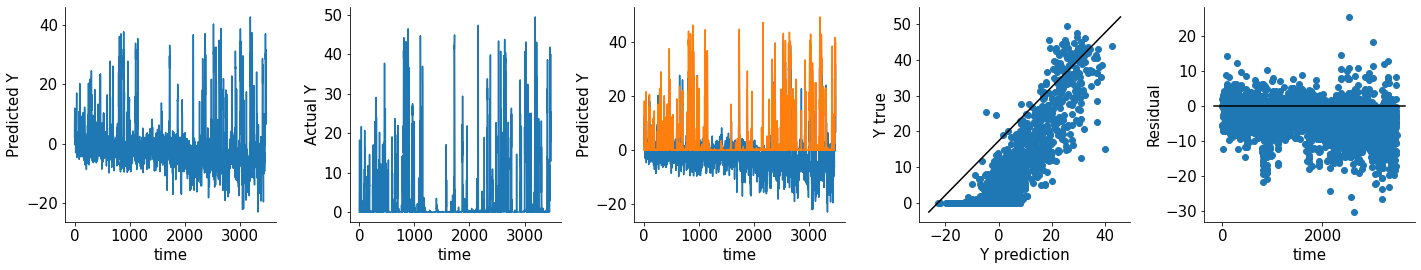

In [ ]:
#Making the missing RRR widget

def whatever_you_want(rank, y_col, Sc_right, beh_measure): 
  #format behavioral data to use with test data

  if beh_measure == 'SVD_time': 
    sbeh = dat['beh_svd_time']
  elif beh_measure == 'run':
    sbeh = dat['run']
  elif beh_measure == 'pupilArea':
    sbeh = dat['pupilArea']

  i_train = np.array([])
  i_test  = np.array([])
  # Every 72s = 60 bins of 1.2s
  for i in range(0, sbeh.shape[0]-60,60):
    if ((i/60) % 2 == 0):
      i_train = np.concatenate((i_train,np.arange(i,i+60)),axis=0)
    else:
      i_test = np.concatenate((i_test,np.arange(i,i+60)),axis=0)   

  print(i_test.shape)
  print(i_train.shape)
  # Make into array of arrays
  i_train = [int(i_train[i]) for i in np.arange(0,len(i_train))]
  i_test = [int(i_test[i]) for i in np.arange(0,len(i_test))]

  sbeh_train = sbeh[i_train,:] 
  sbeh_test  = sbeh[i_train,:]

  print(sbeh_train.shape)
  print(sbeh_test.shape)


  NUM_SAMPLES = np.shape(sbeh_train)[0]
  SPLIT = int(NUM_SAMPLES/2)      # train/test split


  REG = 1e-3 
  print(sbeh_test.shape)
  print(Sc_right.shape)

  if __name__ == '__main__':
      #seed(10)
      model=ReducedRankRegressor
      # generate the data:
      print(model.ideal_data.__doc__)
      #XX, YY = model.ideal_data(sbeh_test.shape[0], DIM_X, DIM_Y, RANK, NOISE_SCALE)
      XX  = Sc_right.T
      YY  = sbeh_test
      # run each of the regressors against it:
      regressor =  ReducedRankRegressor(XX[:SPLIT], YY[:SPLIT], rank, REG)
      print('  {}'.format(regressor))
      training_error = sqerr(regressor.predict(XX[:SPLIT]), YY[:SPLIT])
      testing_error = sqerr(regressor.predict(XX[SPLIT:]), YY[SPLIT:])
      print('    Training error: {}\n    Testing error: {}'
                    .format(training_error, testing_error))
  print('Test: ',XX.shape,YY.shape,y_col)    
  true_v_pred(XX, YY, y_col, regressor)
    
#whatever_you_want(rank = 16, y_col = 0, Sc_right = Sc_left, beh_measure = 'pupilArea')

_= widgets.interact(whatever_you_want, rank=(1,500,1), y_col=0, Sc_right=fixed(Sc_right), 
                    beh_measure = ['run', 'pupilArea', 'SVD_time'])

(0.0, 500.0)

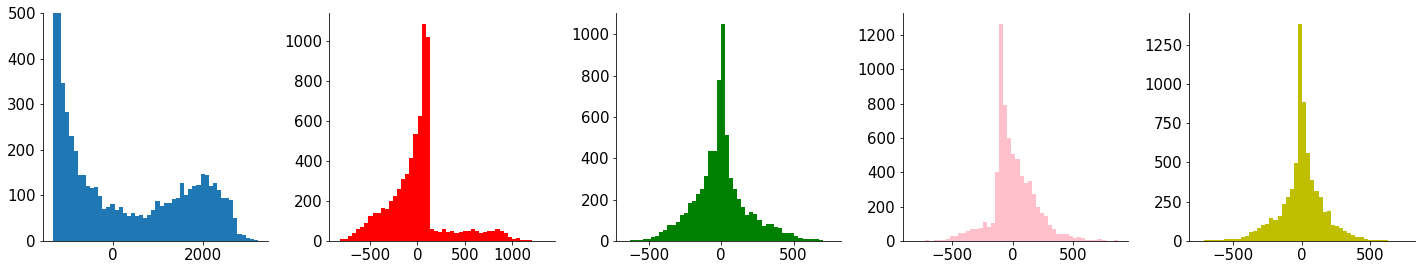

In [ ]:

ax1 = plt.subplot(1,5,1)
plt.hist(X_beh[:,0], bins=50)
ax1.set_ylim(0, 500)

ax2=plt.subplot(1,5,2)
plt.hist(X_beh[:,1], bins=50, color='r')
ax1.set_ylim(0, 500)

ax2=plt.subplot(1,5,3)
plt.hist(X_beh[:,3], bins=50, color='g')
ax1.set_ylim(0, 500)

ax2=plt.subplot(1,5,4)
plt.hist(X_beh[:,4], bins=50, color='pink')
ax1.set_ylim(0, 500)

ax2=plt.subplot(1,5,5)
plt.hist(X_beh[:,5], bins=50, color='y')
ax1.set_ylim(0, 500)


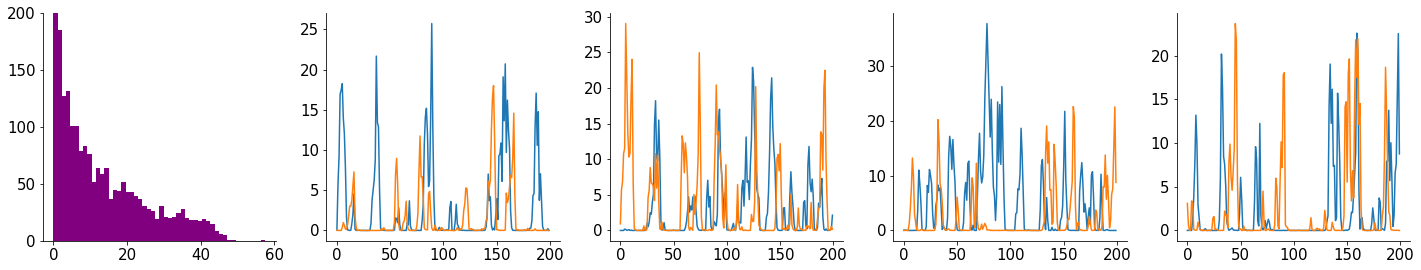

In [ ]:
ax1 = plt.subplot(1,5,1)
plt.hist(dat['run'], bins=50,color='purple')
ax1.set_ylim(0,200)

ax = plt.subplot(1,5,2)
plt.plot(np.arange(0,200), dat['run'][0:200,0])
plt.plot(np.arange(0,200), dat['run'][200:400,0])

ax = plt.subplot(1,5,3)
plt.plot(np.arange(0,200), dat['run'][400:600,0])
plt.plot(np.arange(0,200), dat['run'][600:800,0])

ax = plt.subplot(1,5,4)
plt.plot(np.arange(0,200), dat['run'][800:1000,0])
plt.plot(np.arange(0,200), dat['run'][1000:1200,0])

ax = plt.subplot(1,5,5)
plt.plot(np.arange(0,200), dat['run'][1000:1200,0])
plt.plot(np.arange(0,200), dat['run'][1200:1400,0])



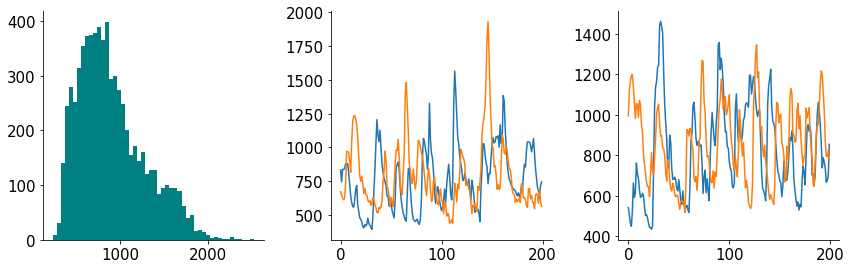

In [ ]:
ax2=plt.subplot(1,5,1)
plt.hist(dat['pupilArea'], bins=50, color='teal')

ax = plt.subplot(1,5,2)
plt.plot(np.arange(0,200), dat['pupilArea'][0:200,0])
plt.plot(np.arange(0,200), dat['pupilArea'][200:400,0])

ax = plt.subplot(1,5,3)
plt.plot(np.arange(0,200), dat['pupilArea'][400:600,0])
plt.plot(np.arange(0,200), dat['pupilArea'][600:800,0])





3.9668140969962598


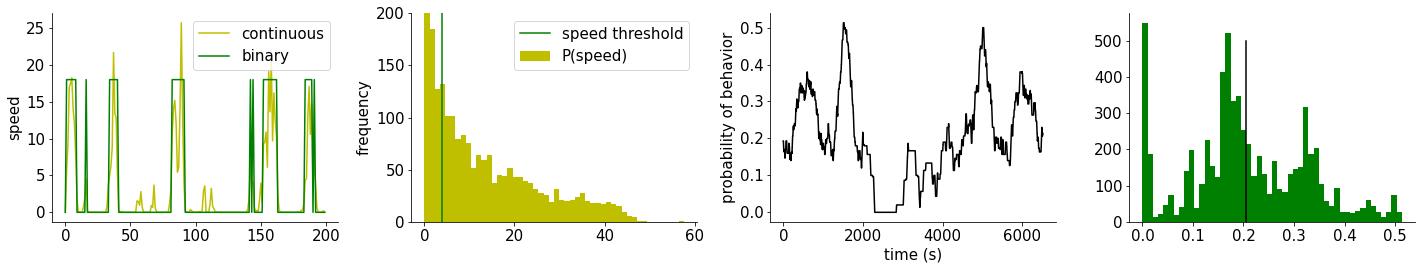

In [ ]:
from skimage.filters import threshold_mean
thresh = threshold_mean(dat['run'])
print(thresh)
binary = dat['run'] > thresh
ax = plt.subplot(1,4,1)
plt.plot(np.arange(0,200), dat['run'][0:200,0], color='y', label='continuous')
plt.plot(np.arange(0,200), binary[0:200]*18, color='green', label='binary')
plt.xlabel('timepoints'); plt.ylabel('speed')
plt.legend()

ax1 = plt.subplot(1,4,2)
plt.hist(dat['run'], bins=50,color='y', label='P(speed)')
plt.plot([thresh, thresh], [0, 500], color='g', label='speed threshold')
ax1.set_ylim(0,200)
plt.xlabel('timepoints'); plt.ylabel('PC1')
plt.legend()

#state_transitions = np.diff(binary,axis=0)
# print(binary[1:-1].shape)
# print(binary[0:-2].shape)
state_transitions = binary[1:-1].astype(int)-binary[0:-2].astype(int)


# # print(state_transitions.shape)
# ax1 = plt.subplot(1,5,3)
# plt.plot(np.arange(0,200), state_transitions[0:200,0], color='green')


window_avg = 300 #WHY ?
av_run_time = np.array([np.mean(binary[i:i+window_avg].astype(int)) for i in np.arange(0,len(binary)-window_avg)])
# print(av_run_time)
# print(av_run_time.shape)
# print(state_transitions.shape)


ax1 = plt.subplot(1,4,3)
plt.plot(np.arange(0,6518), av_run_time[0:6518], color='k')
plt.xlabel('time (s)'); plt.ylabel('probability of behavior')

ax1 = plt.subplot(1,4,4)
plt.hist(av_run_time, bins=50,color='g')
thresh = threshold_mean(av_run_time)
plt.plot([thresh, thresh], [0, 500], color='k')


902.2072883897861


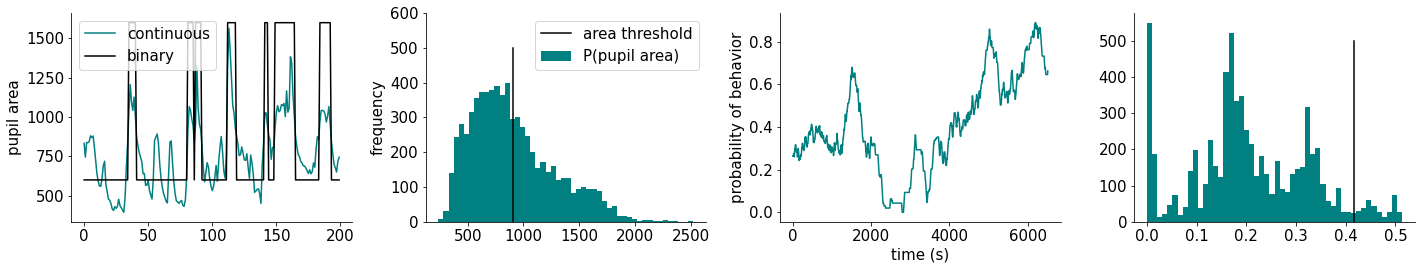

In [ ]:
thresh = threshold_mean(dat['pupilArea'])
print(thresh)
binary = dat['pupilArea'] > thresh
ax = plt.subplot(1,4,1)
plt.plot(np.arange(0,200), dat['pupilArea'][0:200,0], color='teal', label='continuous')
plt.plot(np.arange(0,200), binary[0:200]*1000+600, color='k', label='binary')
plt.xlabel('timepoints'); plt.ylabel('pupil area')
plt.legend()

ax1 = plt.subplot(1,4,2)
plt.hist(dat['pupilArea'], bins=50,color='teal', label='P(pupil area)')
plt.plot([thresh, thresh], [0, 500], color='k', label='area threshold')
ax1.set_ylim(0,600)
plt.xlabel('timepoints'); plt.ylabel('PC1')
plt.legend()

window_avg = 300
av_pupil_time = np.array([np.mean(binary[i:i+window_avg].astype(int)) for i in np.arange(0,len(binary)-window_avg)])
# print(av_pupil_time)
# print(av_pupil_time.shape)
# print(state_transitions.shape)


ax1 = plt.subplot(1,4,3)
plt.plot(np.arange(0,6518), av_pupil_time[0:6518], color='teal')
plt.xlabel('time (s)'); plt.ylabel('probability of behavior')

ax1 = plt.subplot(1,4,4)
plt.hist(av_run_time, bins=50,color='teal')
thresh = threshold_mean(av_pupil_time)
plt.plot([thresh, thresh], [0, 500], color='k')


4.1470262833761335e-15


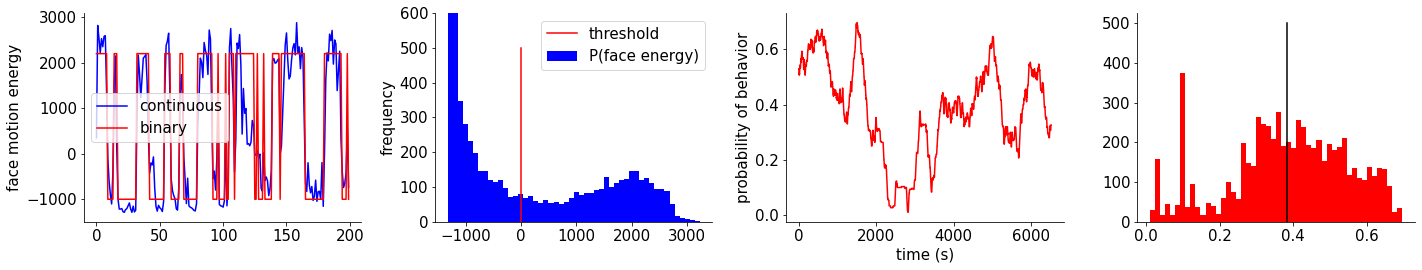

In [ ]:
thresh = threshold_mean(X_beh[:,0])
print(thresh)
binary = X_beh[:,0] > thresh
ax = plt.subplot(1,4,1)
plt.plot(np.arange(0,200), X_beh[0:200,0], color='b', label='continuous')
plt.plot(np.arange(0,200), binary[0:200]*3200-1000, color='r', label='binary')
plt.xlabel('timepoints'); plt.ylabel('face motion energy')
plt.legend()
# plt.show()

ax1 = plt.subplot(1,4,2)
plt.hist(X_beh[:,0], bins=50, color='b', label='P(face energy)')
plt.plot([thresh, thresh], [0, 500], color='r', label='threshold')
ax1.set_ylim(0,600)
plt.xlabel('timepoints'); plt.ylabel('PC1')
plt.legend()

window_avg = 300
av_whisk_time = np.array([np.mean(binary[i:i+window_avg].astype(int)) for i in np.arange(0,len(binary)-window_avg)])
# print(av_whisk_time)
# print(av_whisk_time.shape)
# print(state_transitions.shape)


ax1 = plt.subplot(1,4,3)
plt.plot(np.arange(0,6518), av_whisk_time[0:6518], color='r')
plt.xlabel('time (s)'); plt.ylabel('probability of behavior')

ax1 = plt.subplot(1,4,4)
plt.hist(av_whisk_time, bins=50,color='r')
thresh = threshold_mean(av_whisk_time)
plt.plot([thresh, thresh], [0, 500], color='k')

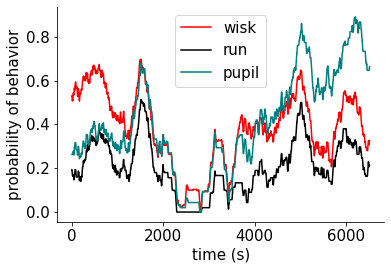

In [ ]:
ax1 = plt.subplot(1,4,1)
plt.plot(np.arange(0,6518), av_whisk_time[0:6518], color='r', label='wisk')
plt.plot(np.arange(0,6518), av_run_time[0:6518], color='k', label='run')
plt.plot(np.arange(0,6518), av_pupil_time[0:6518], color='teal', label='pupil')
plt.xlabel('time (s)'); plt.ylabel('probability of behavior')
plt.legend()

(3, 6518)


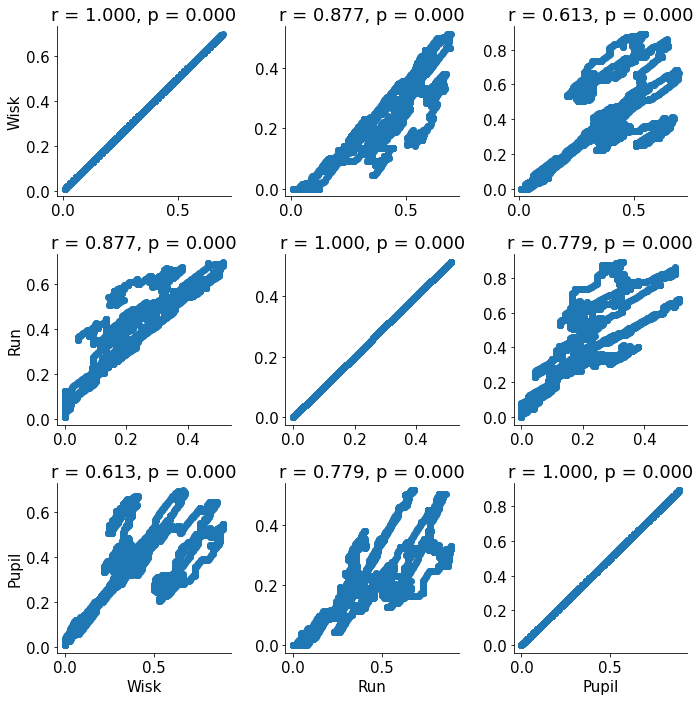

In [ ]:
# correlation visualization 
from scipy import stats
plt.figure(figsize = (10,10));
D = np.squeeze([[av_whisk_time[0:6518]], [av_run_time[0:6518]], [av_pupil_time[0:6518]]])
print(np.shape(D))
count = 1;
for i in range(3):
  for j in range(3):
    # correlation 
    r,p = stats.pearsonr(D[i,:], D[j,:])
    # visualize 
    plt.subplot(3,3,count)
    plt.scatter(D[i,:], D[j,:])
    plt.title(f'r = {r:5.3f}, p = {p:5.3f}')
    count += 1
    # ylabels 
    if i == 0 and j == 0:
      plt.ylabel('Wisk')
    elif i == 1 and j == 0:
      plt.ylabel('Run')
    elif i == 2 and j == 0:
      plt.ylabel('Pupil')
    # xlabels
    if i == 2 and j == 0:
      plt.xlabel('Wisk')
    elif i == 2 and j == 1:
      plt.xlabel('Run')
    elif i == 2 and j == 2:
      plt.xlabel('Pupil')

# plt.savefig('correlation_matrix.png')

(1199, 7018)


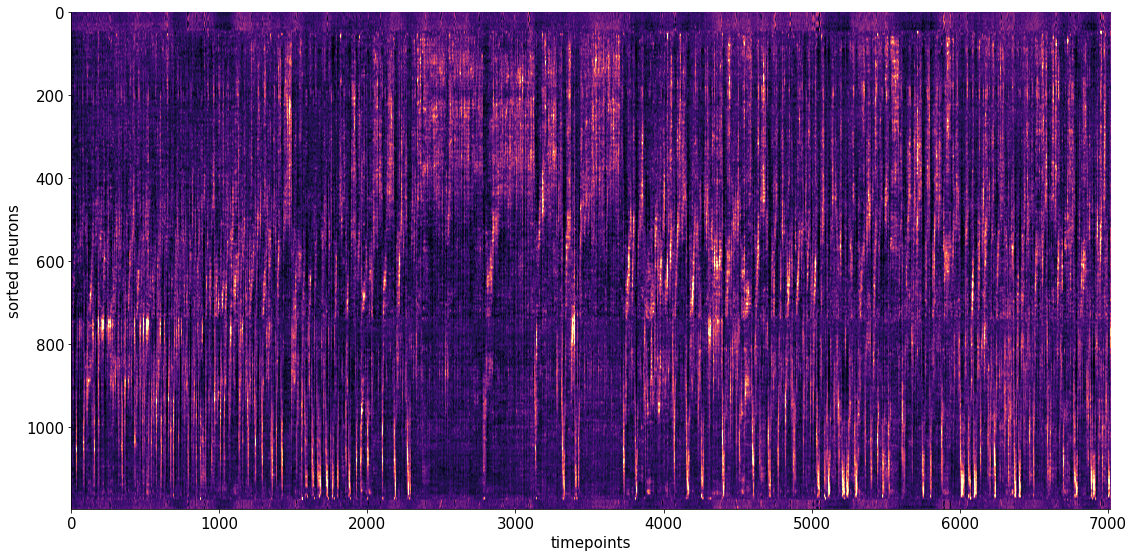

In [ ]:
# Plot UMAP embedding of neural activity
plt.figure(figsize=(16,8))
ax = plt.subplot(111)
print(RasterMap.shape)
trange = np.arange(0, 7018)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

In [ ]:
# Calculate correlations and example encoding and non-encoding neurons
n_window_avg = 300
rx=np.zeros((1199,3))
px=np.zeros((1199,3))
print(trange[-1])
for i in range(1199):
  neuron = np.array([np.mean(RasterMap[i,j:j+window_avg]) for j in np.arange(0,len(trange)-n_window_avg)])
  rx[i,0],px[i,0] = stats.pearsonr(neuron, av_whisk_time)
  rx[i,1],px[i,1] = stats.pearsonr(neuron, av_run_time)
  rx[i,2],px[i,2] = stats.pearsonr(neuron, av_pupil_time)



7017


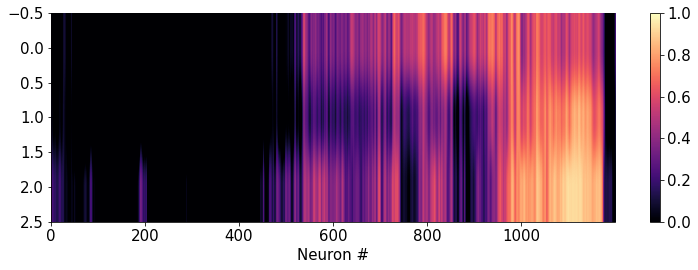

In [ ]:
# Plot correlation between slow neural dynamics and the slow dynamics of behavior
# Plot correlation coefficients heatmap
ax1 = plt.subplot(1,4,1)
plt.imshow(rx.T, vmax= 1, vmin = 0, aspect = 'auto', cmap = 'magma')
plt.xlabel('Neuron #')
# plt.legend()

# Plot example encoding neuron
ax2 = plt.subplot(1,4,2)
neu_act = RasterMap[1100, trange]
n_window_avg = 300
av_n_time = np.array([np.mean(neu_act[i:i+window_avg]) for i in np.arange(0,len(neu_act)-n_window_avg)])
plt.plot(np.arange(0,6518), av_n_time[0:6518], color='purple', label='encoding neuron')
#plt.plot(trange,av_n_time)
plt.xlabel('time (s)'); plt.ylabel('neuronal activity')
plt.legend()

# Plot example non-encoding neuron
ax2 = plt.subplot(1,4,3)
neu_act = RasterMap[800, trange]
n_window_avg = 300
av_n_time = np.array([np.mean(neu_act[i:i+window_avg]) for i in np.arange(0,len(neu_act)-n_window_avg)])
plt.plot(np.arange(0,6518), av_n_time[0:6518], color='k', label='nonencoding neuron')
plt.xlabel('time (s)'); plt.ylabel('neuronal activity')
plt.legend()